### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [ ]:
# Import constants from astropy
from astropy.constants import c as C_LIGHT, G as G_CONST
from astropy import units as u

# Define constants with units for clarity and precision
H_0 = 70 * (u.km / u.s / u.Mpc)  # Hubble constant (Planck 2018 value)
c = C_LIGHT.to(u.m / u.s)        # Speed of light in m/s
G = G_CONST.to(u.Mpc * u.km**2 / u.s**2 / u.Msun)  # Gravitational constant in Mpc (km/s)^2 / M_sun

# Deceleration parameter (as given)
q0 = -0.534  # Assumed from Planck fit (keep this as-is)

# Display all constants for verification
print(f"Hubble constant H_0 = {H_0}")
print(f"Speed of light c = {c}")
print(f"Gravitational constant G = {G}")
print(f"Deceleration parameter q0 = {q0}")


Hubble constant H_0 = 70.0 km / (Mpc s)
Speed of light c = 299792458.0 m / s
Gravitational constant G = 4.300917270036279e-09 km2 Mpc / (solMass s2)
Deceleration parameter q0 = -0.534


Read the csv data into the python using the method below

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Skyserver_SQL6_22_2025 12_55_32 PM.csv", skiprows=1)  # <- Replace with your downloaded SDSS file
df.rename(columns={df.columns[0]: 'objid'}, inplace=True)
print(df.head())

Saving Skyserver_SQL6_22_2025 12_55_32 PM.csv to Skyserver_SQL6_22_2025 12_55_32 PM.csv
                 objid         ra        dec    photoz  photozerr     specz  \
0  1237671768542478711  257.82458  64.133257  0.079193   0.022867  0.082447   
1  1237671768542478711  257.82458  64.133257  0.079193   0.022867  0.082466   
2  1237671768542478713  257.83332  64.126043  0.091507   0.014511  0.081218   
3  1237671768542544090  257.85137  64.173247  0.081102   0.009898  0.079561   
4  1237671768542544090  257.85137  64.173247  0.081102   0.009898  0.079568   

   speczerr  proj_sep      umag   umagerr      gmag   gmagerr      rmag  \
0  0.000017  8.347733  18.96488  0.043377  17.49815  0.005672  16.75003   
1  0.000014  8.347733  18.96488  0.043377  17.49815  0.005672  16.75003   
2  0.000021  8.011259  20.22848  0.072019  18.38334  0.007763  17.46793   
3  0.000022  8.739276  19.21829  0.050135  17.18970  0.004936  16.22043   
4  0.000019  8.739276  19.21829  0.050135  17.18970  0.004936 

### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [ ]:
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',
    'ra': 'first',
    'dec': 'first',
    'proj_sep': 'first',
}).reset_index()

# View descriptive statistics
averaged_df.describe()['specz']

,specz
count,92.000000
mean,0.080838
std,0.008578
min,0.069976
25%,0.077224
50%,0.080961
75%,0.082797
max,0.150886


To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group.

Find the mean, standard deviation and limits of the redshift from the data

In [ ]:
# Calculate mean and standard deviation of redshift for clustering logic
mean_z = averaged_df['specz'].mean()
std_z = averaged_df['specz'].std()
z_lower = mean_z - 3 * std_z
z_upper = mean_z + 3 * std_z

print(f"Mean redshift: {mean_z:.5f}")
print(f"Standard deviation: {std_z:.5f}")
print(f"Redshift cut: {z_lower:.5f} to {z_upper:.5f}")

Mean redshift: 0.08084
Standard deviation: 0.00858
Redshift cut: 0.05510 to 0.10657


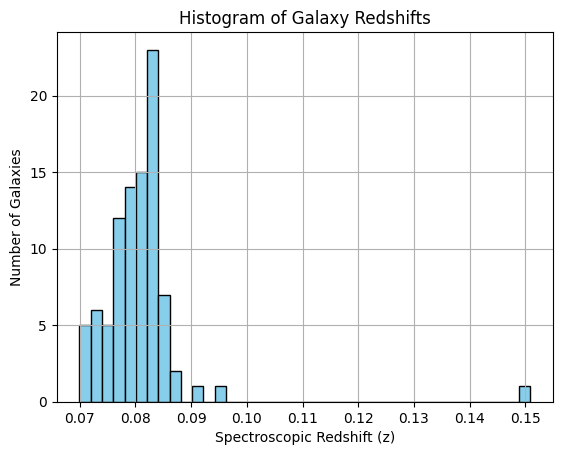

In [ ]:
# Plot histogram of redshifts
plt.hist(averaged_df['specz'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Spectroscopic Redshift (z)")
plt.ylabel("Number of Galaxies")
plt.title("Histogram of Galaxy Redshifts")
plt.grid(True)
plt.show()

You can also use boxplot to visualize the overall values of redshift

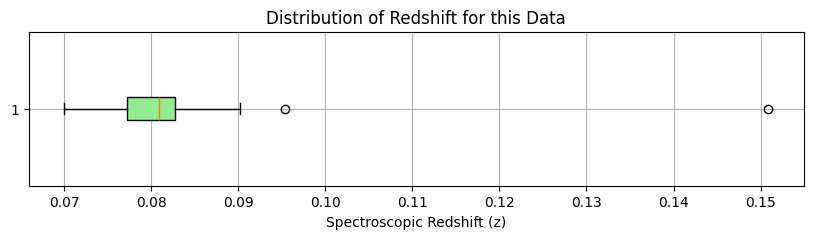

In [ ]:
# Also show redshift distribution using a boxplot
plt.figure(figsize=(10, 2))
plt.boxplot(averaged_df['specz'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title("Distribution of Redshift for this Data")
plt.xlabel("Spectroscopic Redshift (z)")
plt.grid(True)
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

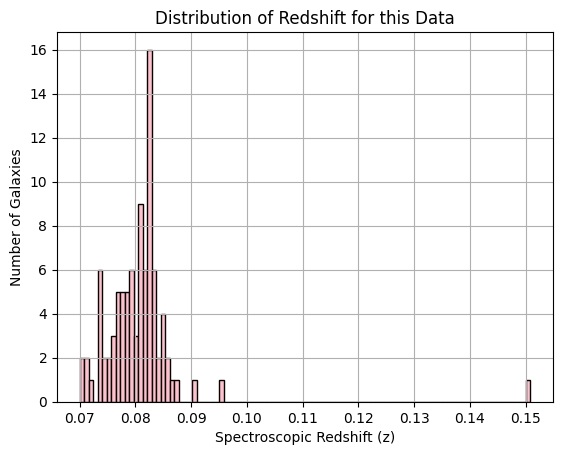

In [ ]:
# Plot histogram of redshifts with more bins for detail
plt.hist(averaged_df['specz'], bins=100, color='pink', edgecolor='black')
plt.xlabel("Spectroscopic Redshift (z)")
plt.ylabel("Number of Galaxies")
plt.title("Distribution of Redshift for this Data")
plt.grid(True)
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [ ]:
# Set cluster_members from the filtered averaged_df
cluster_members = averaged_df
print(f"Number of cluster members: {len(cluster_members)}")

# Cluster Redshift and Velocity Dispersion
z_cluster = cluster_members['specz'].mean()
velocities = (3e5 * (cluster_members['specz'] - z_cluster) / (1 + z_cluster))  # km/s
sigma_v = velocities.std()

print(f"Mean cluster redshift: {z_cluster:.5f}")
print(f"Velocity dispersion: {sigma_v:.2f} km/s")


Number of cluster members: 92
Mean cluster redshift: 0.08084
Velocity dispersion: 2380.82 km/s


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift

In [ ]:
# Add a column for expansion velocity based on redshift
# v = c * z (non-relativistic approximation)
averaged_df['velocity'] = averaged_df['specz'] * (c.to(u.km / u.s).value)


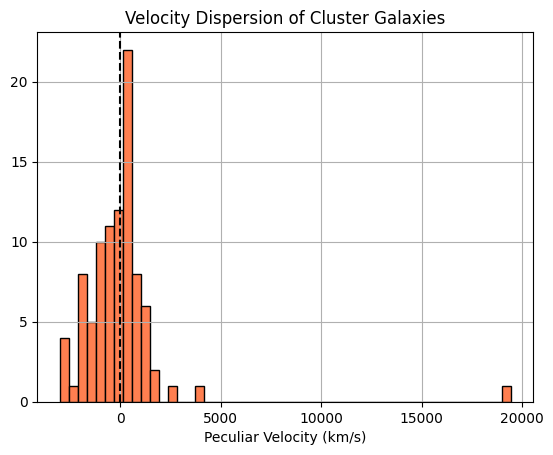

In [ ]:
#plot the velocity column created as hist
# Plot velocity dispersion
plt.hist(velocities, bins=50, color='coral', edgecolor='black')
plt.xlabel("Peculiar Velocity (km/s)")
plt.title("Velocity Dispersion of Cluster Galaxies")
plt.axvline(0, color='k', linestyle='--')
plt.grid(True)
plt.show()

use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

In [ ]:
# Use the dispersion equation (standard deviation of velocities)
sigma_v = ((velocities - velocities.mean())**2).mean()**0.5  # equivalent to np.std(velocities)

print(f"Mean cluster redshift: {z_cluster:.5f}")
print(f"Velocity dispersion (from dispersion equation): {sigma_v:.2f} km/s")

# Velocity dispersion is a crucial quantity in astrophysics. It helps identify the degree to which galaxies in a cluster deviate from the average expansion velocity, and can even suggest whether multiple substructures or larger superclusters are involved.


Mean cluster redshift: 0.08084
Velocity dispersion (from dispersion equation): 2367.85 km/s


### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [ ]:
# Set cluster_members from the filtered averaged_df
cluster_members = averaged_df
print(f"Number of cluster members: {len(cluster_members)}")

# Step 2: Calculate Mean Redshift of the Cluster
z_cluster = cluster_members['specz'].mean()
print(f"Mean cluster redshift: {z_cluster:.5f}")

# Relativistic Doppler formula for velocity dispersion
z = cluster_members['specz']
z_c = z_cluster
c_km = c.to(u.km / u.s).value

doppler_numerator = (1 + z)**2 - (1 + z_c)**2
doppler_denominator = (1 + z)**2 + (1 + z_c)**2
velocities = c_km * (doppler_numerator / doppler_denominator)

# Use the dispersion equation (standard deviation of velocities)
sigma_v = velocities.std()



Number of cluster members: 92
Mean cluster redshift: 0.08084


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [ ]:
# Quick look stats for dispersion column using describe
print("Descriptive statistics for velocity dispersion:")
print(velocities.describe())

Descriptive statistics for velocity dispersion:
count       92.000000
mean        -9.324504
std       2323.653439
min      -3027.796284
25%      -1004.038639
50%         34.119810
75%        543.012883
max      18801.015195
Name: specz, dtype: float64


In [ ]:
# Print results
print(f"The value of the cluster redshift = {z_cluster:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {sigma_v:.4} km/s.")


The value of the cluster redshift = 0.08084
The characteristic value of velocity dispersion of the cluster along the line of sight = 2.324e+03 km/s.


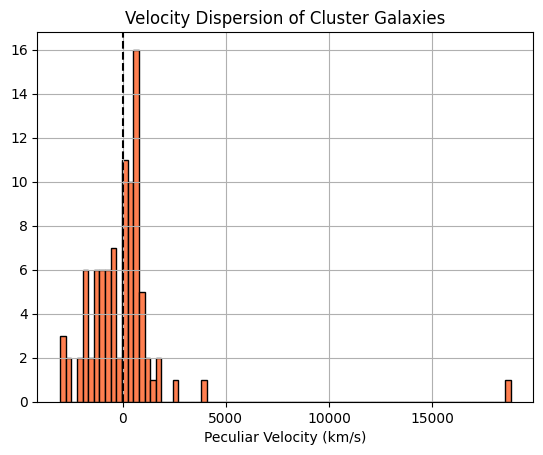

In [ ]:
# Plot velocity dispersion
plt.hist(velocities, bins=80, color='coral', edgecolor='black')
plt.xlabel("Peculiar Velocity (km/s)")
plt.title("Velocity Dispersion of Cluster Galaxies")
plt.axvline(0, color='k', linestyle='--')
plt.grid(True)
plt.show()


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



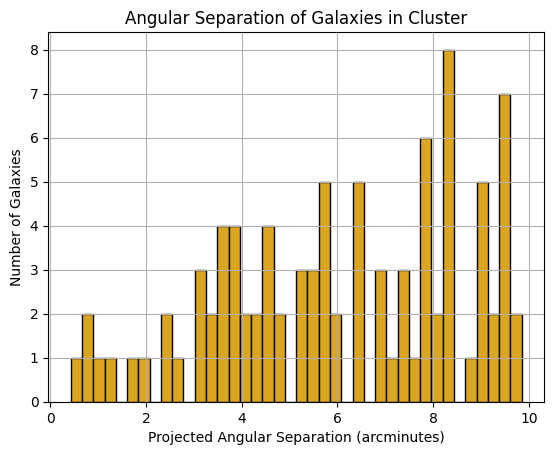

In [ ]:
#Plot histogram for proj sep column
plt.hist(cluster_members['proj_sep'], bins=40, color='goldenrod', edgecolor='black')
plt.xlabel("Projected Angular Separation (arcminutes)")
plt.ylabel("Number of Galaxies")
plt.title("Angular Separation of Galaxies in Cluster")
plt.grid(True)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [ ]:
# Co-moving distance using Taylor expansion for low-z
z = z_cluster
r = (c.to(u.km/u.s).value * z) / (H_0.to(u.km/u.s/u.Mpc).value * (1 - z * (1 + q0) / 2))

# Angular diameter distance
D_A = r / (1 + z)

# Convert average angular size from arcminutes to radians
theta_rad = (cluster_members['proj_sep'].mean() * u.arcmin).to(u.rad).value

# Physical diameter in Mpc
diameter = D_A * theta_rad
print(f"r (co-moving distance): {r:.3f} Mpc")
print(f"D_A (angular diameter distance): {D_A:.3f} Mpc")
print(f"Estimated physical diameter of cluster: {diameter:.3f} Mpc")

r (co-moving distance): 352.853 Mpc
D_A (angular diameter distance): 326.463 Mpc
Estimated physical diameter of cluster: 0.575 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [ ]:
### Calculating the dynamical mass in solar masses:
# Using virial theorem: Mdyn = 3σ²R / G
# Convert σ to m/s and radius (diameter/2) to meters
disp = sigma_v
M_dyn = 3 * ((disp * 1000)**2) * (diameter * 0.5 * 1e6 * 3e16) / (G.to(u.m**3 / u.kg / u.s**2).value * 2e30)
print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 1.05e+15 solar mass


In [ ]:
from numpy import log10
L_sun_r = 4.67

def luminosity_r(mag, z):
    d_l = cosmo.luminosity_distance(z).to(u.pc).value
    M_r = mag - 5 * log10(d_l / 10)
    return 10**(-0.4 * (M_r - L_sun_r))

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H_0.value, Om0=0.3)
# Use the original df for luminosity calculation as it contains magnitude columns
df['L_r'] = df.apply(lambda row: luminosity_r(row['rmag'], row['specz']), axis=1)

# Group by objid and sum the luminosities for each object
L_total = df.groupby('objid')['L_r'].sum().sum()

M_luminous = 5 * L_total
print(f"Total luminous mass: {M_luminous:.2e} M_sun")
print(f"Ratio (M_dyn / M_luminous): {M_dyn / M_luminous:.2f}")

Total luminous mass: 1.87e+13 M_sun
Ratio (M_dyn / M_luminous): 56.11


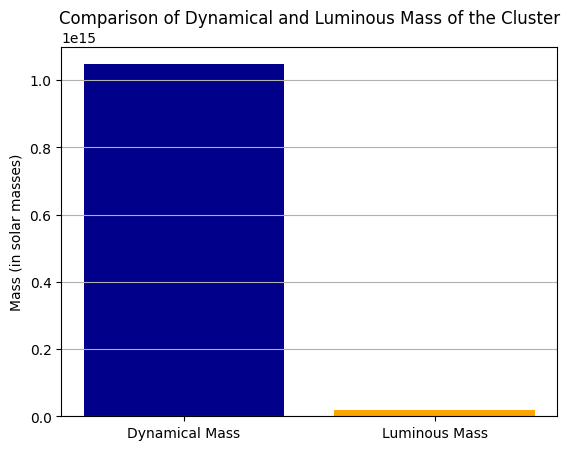

In [ ]:
# Comparison plot
plt.bar(['Dynamical Mass', 'Luminous Mass'], [M_dyn, M_luminous], color=['darkblue', 'orange'])
plt.ylabel('Mass (in solar masses)')
plt.title('Comparison of Dynamical and Luminous Mass of the Cluster')
plt.grid(True, axis='y')
plt.show()

# **Comparison of Dynamical mass with Luminous mass**

The large difference is expected due to dark matter, which contributes to the dynamical mass but not to the luminous mass.

In [ ]:
#  Interpretation of Mass Comparison
print("\nInterpretation:")
if M_dyn > M_luminous:
    print(f"The dynamical mass (≈ {M_dyn:.2e} M_sun) is significantly greater than the luminous mass (≈ {M_luminous:.2e} M_sun).")
    print("This discrepancy is expected because luminous mass only accounts for the baryonic (visible) matter like stars and gas.")
    print("The higher dynamical mass implies the presence of dark matter, which dominates the total mass of galaxy clusters.")
    print("This supports the current cosmological understanding that dark matter forms the majority of mass in clusters.")
else:
    print("The dynamical and luminous masses are nearly equal, which may suggest underestimation of velocity dispersion or overestimation of luminosity.")
    print("Further investigation would be needed, but such a scenario is less common in observational cosmology.")



Interpretation:
The dynamical mass (≈ 1.05e+15 M_sun) is significantly greater than the luminous mass (≈ 1.87e+13 M_sun).
This discrepancy is expected because luminous mass only accounts for the baryonic (visible) matter like stars and gas.
The higher dynamical mass implies the presence of dark matter, which dominates the total mass of galaxy clusters.
This supports the current cosmological understanding that dark matter forms the majority of mass in clusters.
